In [17]:
import os
import warnings

warnings.filterwarnings(action='ignore', message='numpy.dtype size changed')
warnings.filterwarnings(action='ignore', message='compiletime version 3.5 of module')

if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
os.chdir(os.path.split(workbookDir)[0])

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from synthesized.testing.evaluation import Evaluation
from synthesized.testing.synthetic_distributions import *

evaluation = Evaluation(config_path='../synthesized/configs/evaluation/synthetic_distributions.json', name='synthetic')

### Gauss "ball" outside of center

In [ ]:
data = create_gauss_ball(x_mean=1000, x_std=100, y_mean=100, y_std=10, size=10000)

In [ ]:
synthesize_and_plot(data, name='ball', evaluation=evaluation)

### Gauss "ball" around of zero

In [ ]:
data = create_gauss_ball(x_mean=0, x_std=100, y_mean=0, y_std=10, size=10000)

In [ ]:
synthesize_and_plot(data, name='ball_ext', evaluation=evaluation)

### Line of noise that far from zero

In [ ]:
data = create_gauss_line(x_range=(0, 1000), intercept=100, slope=-0.1, y_std=10, size=10000)

In [ ]:
synthesize_and_plot(data, name='line', evaluation=evaluation)

### Line of noise that comes from zero

In [ ]:
data = create_gauss_line(x_range=(0, 1000), intercept=0, slope=0.1, y_std=10, size=10000)

In [ ]:
synthesize_and_plot(data, name='line_ext', evaluation=evaluation)

### Power law distribution

In [ ]:
data = create_power_law_distribution(shape=0.5, scale=1000, size=10000)

In [ ]:
synthesize_and_plot(data, name='power_law', evaluation=evaluation)

### Conditional distribution

In [ ]:
data = create_conditional_distibution((10,2), (20,5), (30,1), size=10000)

In [ ]:
synthesize_and_plot(data, name='conditional', evaluation=evaluation)

### Bernoulli distribution

In [ ]:
data = create_bernoulli_distribution(ratio=0.5, size=10000)

In [ ]:
synthesize_and_plot(data, name='bernoulli_50/50', evaluation=evaluation)

In [ ]:
data = create_bernoulli_distribution(ratio=0.2, size=10000)

In [ ]:
synthesize_and_plot(data, name='bernoulli_20/80', evaluation=evaluation)

### Categorical distribution

In [ ]:
data = create_unifom_categorical(n_classes=10, size=10000)

In [ ]:
synthesize_and_plot(data, name='categorical_uniform', evaluation=evaluation)

In [ ]:
data = create_power_law_categorical(n_classes=10, size=10000)

In [ ]:
synthesize_and_plot(data, name='categorical_powerlaw', evaluation=evaluation)

In [ ]:
evaluation.write_metrics()

### Multimodal distributions


took 126.71898174285889 s


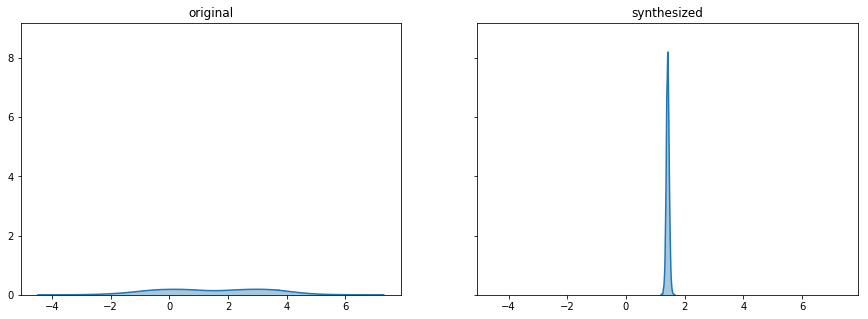

In [20]:
data = create_two_1d_gaussians(mean1 = 0, std1 =1, size1 = 1000, mean2 =3, std2 = 1, size2 = 1000)
synthesize_and_plot(data, name='mixture of gaussians', evaluation=evaluation)


took 128.9735279083252 s


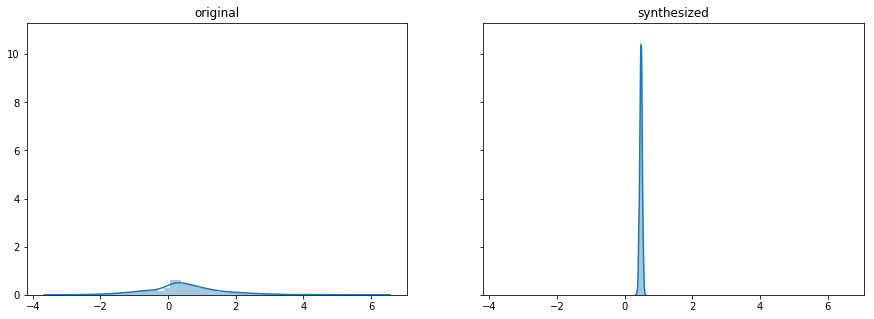

In [21]:
data = create_expon_gaussian_mixture(mean1 = 0, std1 = 1, size1 = 1000, scale = 1, size2 = 1000)
synthesize_and_plot(data, name='gaussians and exponential', evaluation=evaluation)


took 143.75873589515686 s


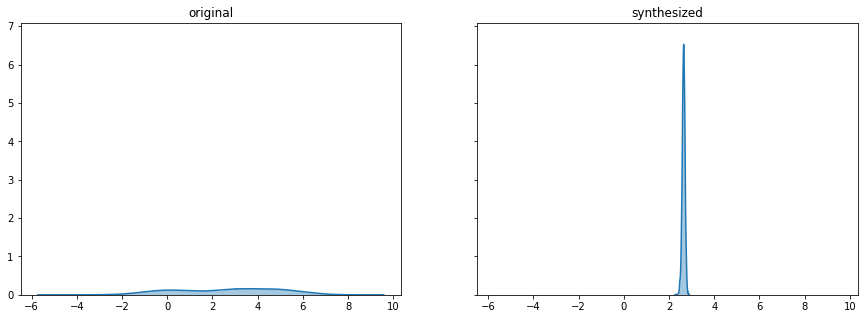

In [24]:
data = create_three_1d_gaussians(mean1 = 0, std1 =1, size1 = 1000, mean2 =3, std2 = 1, size2 = 1000, mean3 = 5, std3 =1, size3 = 1000)
synthesize_and_plot(data, name='mixture of 3 gaussians', evaluation=evaluation)